In [1]:
# Imports basics
import numpy as np
import h5py
import json
import setGPU
import sklearn
import corner

# Imports neural net tools
import itertools
import torch
import torch.nn as nn
from torch.autograd.variable import *
import torch.optim as optim
import torch.nn.functional as F
from fast_soft_sort.pytorch_ops import soft_rank
import matplotlib.pyplot as plt

setGPU: Setting GPU to: 0


In [2]:
# Opens files and reads data

print("Extracting")
outdir = 'data/IN_FlatSamples_Pytorch'
fOne = h5py.File("data/FullQCD_FullSig_Zqq_fillfactor1_pTsdmassfilling_dRlimit08_50particlesordered_bkgFill_genMatched50.h5", 'r')
print(fOne.keys())
totalData = fOne["deepDoubleQ"][:]
print(totalData.shape)


Extracting
<KeysViewHDF5 ['deepDoubleQ']>
(3075307, 207)


In [3]:
# Sets controllable values

particlesConsidered = 50
particlesPostCut = 50
entriesPerParticle = 4
eventDataLength = 6
decayTypeColumn = -1
datapoints = 1400000
trainingDataLength = int(len(totalData)*0.8)
validationDataLength = int(len(totalData)*0.1)

In [4]:
# Creates Training Data

print("Preparing Data")

particleDataLength = particlesConsidered * entriesPerParticle

np.random.seed(42)
np.random.shuffle(totalData)

#trainingDataLength = int(datapoints*0.8)
#validationDataLength = int(datapoints*0.1)

mask = [i>40 for i in totalData[:, eventDataLength-1]]
totalData = totalData[mask]

labels = totalData[:, decayTypeColumn:]
particleData = totalData[:, eventDataLength:particleDataLength + eventDataLength]
eventData = totalData[:, :eventDataLength]
jetMassData = totalData[:, eventDataLength-1] #last entry in eventData (zero indexing)


######### Training Data ###############
eventTrainingData = np.array(eventData[0:trainingDataLength])
jetMassTrainingData = np.array(jetMassData[0:trainingDataLength])
particleTrainingData = np.transpose(
    particleData[0:trainingDataLength, ].reshape(trainingDataLength, 
                                                 entriesPerParticle, 
                                                 particlesConsidered),
                                                 axes=(0, 1, 2))
trainingLabels = np.array([[i, 1-i] for i in labels[0:trainingDataLength]]).reshape((-1, 2))
print(particleTrainingData.shape)

########## Validation Data ##########
eventValidationData = np.array(eventData[trainingDataLength:trainingDataLength + validationDataLength])
jetMassValidationData = np.array(jetMassData[trainingDataLength:trainingDataLength + validationDataLength])
particleValidationData = np.transpose(
    particleData[trainingDataLength:trainingDataLength + validationDataLength, ].reshape(validationDataLength,
                                                                                         entriesPerParticle,
                                                                                         particlesConsidered),
                                                                                         axes=(0, 1, 2))
validationLabels = np.array([[i, 1-i] for i in labels[trainingDataLength:trainingDataLength + validationDataLength]]).reshape((-1, 2))
print(particleValidationData.shape)


########### Testing Data ############
eventTestData = np.array(eventData[trainingDataLength + validationDataLength:])
jetMassTestData = np.array(jetMassData[trainingDataLength + validationDataLength:])
particleTestData = np.transpose(particleData[trainingDataLength + validationDataLength:,].reshape(
    len(particleData) - trainingDataLength - validationDataLength, entriesPerParticle, particlesConsidered),
                                axes=(0, 1, 2))
testLabels = np.array([[i, 1-i] for i in labels[trainingDataLength + validationDataLength:]]).reshape((-1, 2))

print('Selecting particlesPostCut')
particleTrainingData = particleTrainingData[:, :particlesPostCut]
particleValidationData = particleValidationData[:, :particlesPostCut]
particlesTestData = particleTestData[:, :particlesPostCut]

particlesConsidered = particlesPostCut

# Separating signal and bkg arrays
particleTrainingDataSig = particleTrainingData[trainingLabels[:,0].astype(bool)]
particleTrainingDataBkg = particleTrainingData[trainingLabels[:,1].astype(bool)]
particleValidationDataSig = particleValidationData[validationLabels[:,0].astype(bool)]
particleValidationDataBkg = particleValidationData[validationLabels[:,1].astype(bool)]
particleTrainingLabelSig = trainingLabels[trainingLabels[:,0].astype(bool)]
particleTrainingLabelBkg = trainingLabels[trainingLabels[:,1].astype(bool)]

# Jet mass for correlation
jetMassTrainingDataSig = jetMassTrainingData[trainingLabels[:,0].astype(bool)]
jetMassTrainingDataBkg = jetMassTrainingData[trainingLabels[:,1].astype(bool)]
jetMassValidationDataSig = jetMassValidationData[validationLabels[:,0].astype(bool)]
jetMassValidationDataBkg = jetMassValidationData[validationLabels[:,1].astype(bool)]


Preparing Data
(2460245, 4, 50)
(307530, 4, 50)
Selecting particlesPostCut


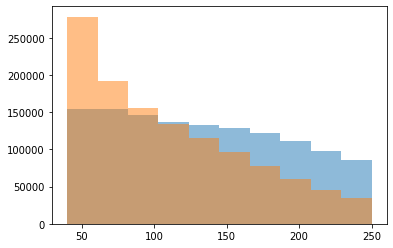

In [5]:
# Look at the data a bit!
plt.figure()
plt.hist(jetMassTrainingDataSig, alpha=0.5)
plt.hist(jetMassTrainingDataBkg, alpha=0.5)
#plt.hist(jetMassValidationDataSig, density=True, alpha=0.5)
#plt.hist(jetMassValidationDataBkg, density=True, alpha=0.5)
plt.show()


In [6]:
# Defines the interaction matrices
class GraphNetnoSV(nn.Module):
    def __init__(self, n_constituents, n_targets, params, hidden, De=5, Do=6, softmax=False):
        super(GraphNetnoSV, self).__init__()
        self.hidden = int(hidden)
        self.P = params
        self.Nv = 0 
        self.N = n_constituents
        self.Nr = self.N * (self.N - 1)
        self.Nt = self.N * self.Nv
        self.Ns = self.Nv * (self.Nv - 1)
        self.Dr = 0
        self.De = De
        self.Dx = 0
        self.Do = Do
        self.S = 0
        self.n_targets = n_targets
        self.assign_matrices()
           
        self.Ra = torch.ones(self.Dr, self.Nr)
        self.fr1 = nn.Linear(2 * self.P + self.Dr, self.hidden).cuda()
        self.fr2 = nn.Linear(self.hidden, int(self.hidden/2)).cuda()
        self.fr3 = nn.Linear(int(self.hidden/2), self.De).cuda()
        self.fr1_pv = nn.Linear(self.S + self.P + self.Dr, self.hidden).cuda()
        self.fr2_pv = nn.Linear(self.hidden, int(self.hidden/2)).cuda()
        self.fr3_pv = nn.Linear(int(self.hidden/2), self.De).cuda()
        
        self.fo1 = nn.Linear(self.P + self.Dx + (self.De), self.hidden).cuda()
        self.fo2 = nn.Linear(self.hidden, int(self.hidden/2)).cuda()
        self.fo3 = nn.Linear(int(self.hidden/2), self.Do).cuda()
        
        self.fc_fixed = nn.Linear(self.Do, self.n_targets).cuda()
        self.activation = torch.nn.ReLU()
            
    def assign_matrices(self):
        self.Rr = torch.zeros(self.N, self.Nr)
        self.Rs = torch.zeros(self.N, self.Nr)
        receiver_sender_list = [i for i in itertools.product(range(self.N), range(self.N)) if i[0]!=i[1]]
        for i, (r, s) in enumerate(receiver_sender_list):
            self.Rr[r, i] = 1
            self.Rs[s, i] = 1
        self.Rr = (self.Rr).cuda()
        self.Rs = (self.Rs).cuda()

    def forward(self, x):
        ###PF Candidate - PF Candidate###
        Orr = self.tmul(x, self.Rr)
        Ors = self.tmul(x, self.Rs)
        B = torch.cat([Orr, Ors], 1)
        ### First MLP ###
        B = torch.transpose(B, 1, 2).contiguous()
        B = nn.functional.relu(self.fr1(B.view(-1, 2 * self.P + self.Dr)))
        B = nn.functional.relu(self.fr2(B))
        E = nn.functional.relu(self.fr3(B).view(-1, self.Nr, self.De))
        del B
        E = torch.transpose(E, 1, 2).contiguous()
        Ebar_pp = self.tmul(E, torch.transpose(self.Rr, 0, 1).contiguous())
        del E
        

        ####Final output matrix for particles###
        

        C = torch.cat([x, Ebar_pp], 1)
        del Ebar_pp
        C = torch.transpose(C, 1, 2).contiguous()
        ### Second MLP ###
        C = nn.functional.relu(self.fo1(C.view(-1, self.P + self.Dx + (self.De))))
        C = nn.functional.relu(self.fo2(C))
        O = nn.functional.relu(self.fo3(C).view(-1, self.N, self.Do))
        del C

        
        #Taking the sum of over each particle/vertex
        N = torch.sum(O, dim=1)
        del O
        
        ### Classification MLP ###

        N = self.fc_fixed(N)
        
        if softmax:
            N = nn.Softmax(dim=1)(N)
        
        return self.activation(N)
            
    def tmul(self, x, y):  #Takes (I * J * K)(K * L) -> I * J * L 
        x_shape = x.size()
        y_shape = y.size()
        return torch.mm(x.view(-1, x_shape[2]), y).view(-1, x_shape[1], y_shape[1])
    
    
class DNN(nn.Module):
    def __init__(self, n_targets):
        super(DNN, self).__init__()
        #self.flat = torch.flatten()
        self.f0 = nn.Linear(200, 400).cuda()
        self.f0b = nn.Linear(400, 400).cuda()
        self.f1 = nn.Linear(400, 100).cuda()
        self.f2 = nn.Linear(100, 50).cuda()
        self.f3 = nn.Linear(50, 10).cuda()
        self.f4 = nn.Linear(10, n_targets).cuda()
        self.activation = torch.nn.Sigmoid()
    def forward(self, x): 
        x = torch.flatten(x,start_dim=1)
        x = self.f0(x)
        x = self.f0b(x)
        x = self.f1(x)
        x = self.f2(x)
        x = self.f3(x)
        x = self.f4(x)
        return(self.activation(x))

class MLP(nn.Module):
    def __init__(self, n_inputs, n_targets):
        super(MLP, self).__init__()
        self.f1 = nn.Linear(n_inputs, n_inputs).cuda()
        self.f2 = nn.Linear(n_inputs, int(n_inputs/2)).cuda()
        self.f3 = nn.Linear(int(n_inputs/2), n_targets).cuda()
        self.activation = torch.nn.Softmax()
    def forward(self, x): 
        x = self.f1(x)
        x = self.f2(x)
        x = self.f3(x)
        return(self.activation(x))

class Linear(nn.Module):
    def __init__(self, n_inputs, n_targets):
        super(Linear, self).__init__()
        self.f1 = nn.Linear(n_inputs, n_targets).cuda()
        self.activation = torch.nn.Softmax()
    def forward(self, x): 
        x = self.f1(x)
        return(self.activation(x))

In [7]:
# Define losses 
class BarlowTwinsLoss(torch.nn.Module):

    def __init__(self, lambda_param=5e-3):
        super(BarlowTwinsLoss, self).__init__()
        self.lambda_param = lambda_param
        self.device = torch.device('cuda:0')

    def forward(self, z_a: torch.Tensor, z_b: torch.Tensor):
        #self.device = (torch.device('cuda')if z_a.is_cuda else torch.device('cpu'))
        # normalize repr. along the batch dimension
        z_a_norm = (z_a - z_a.mean(0)) / z_a.std(0) # NxD
        z_b_norm = (z_b - z_b.mean(0)) / z_b.std(0) # NxD

        N = z_a.size(0)
        D = z_a.size(1)

        # cross-correlation matrix
        c = torch.mm(z_a_norm.T, z_b_norm) / N # DxD
        # loss
        c_diff = (c - torch.eye(D, device=self.device)).pow(2) # DxD
        # multiply off-diagonal elems of c_diff by lambda
        c_diff[~torch.eye(D, dtype=bool)] *= self.lambda_param
        loss = c_diff.sum()
        return loss

    
# return a flattened view of the off-diagonal elements of a square matrix
def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

class VICRegLoss(torch.nn.Module):

    def __init__(self, lambda_param=1,mu_param=1,nu_param=20):
        super(VICRegLoss, self).__init__()
        self.lambda_param = lambda_param
        self.mu_param = mu_param
        self.nu_param = nu_param
        #self.device = torch.device('cpu')

    def forward(self, x, y):
        self.device = (torch.device('cuda')if x.is_cuda else torch.device('cpu'))
        
        x_scale = x
        y_scale = y
        repr_loss = F.mse_loss(x_scale, y_scale)
        
        #x = torch.cat(FullGatherLayer.apply(x), dim=0)
        #y = torch.cat(FullGatherLayer.apply(y), dim=0)
        x = x_scale - x_scale.mean(dim=0)
        y = y_scale - y_scale.mean(dim=0)
        N = x_scale.size(0)
        D = x_scale.size(1)
        
        std_x = torch.sqrt(x_scale.var(dim=0) + 0.0001)
        std_y = torch.sqrt(y_scale.var(dim=0) + 0.0001)
        std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

        cov_x = (x_scale.T @ x_scale) / (N - 1)
        cov_y = (y_scale.T @ y_scale) / (N - 1)
        cov_loss = off_diagonal(cov_x).pow_(2).sum().div(D) + off_diagonal(cov_y).pow_(2).sum().div(D)

        #loss = (self.lambda_param * repr_loss + self.mu_param * std_loss+ self.nu_param * cov_loss)
        #print(repr_loss,cov_loss,std_loss)
        return repr_loss,cov_loss,std_loss
    
class CorrLoss(nn.Module):
    def __init__(self, corr=False,sort_tolerance=1.0,sort_reg='l2'):
        super(CorrLoss, self).__init__()
        self.tolerance = sort_tolerance
        self.reg       = sort_reg
        self.corr      = corr
        
    def spearman(self, pred, target):
        pred   = soft_rank(pred.cpu().reshape(1,-1),regularization=self.reg,regularization_strength=self.tolerance,)
        target = soft_rank(target.cpu().reshape(1,-1),regularization=self.reg,regularization_strength=self.tolerance,)
        #pred   = torchsort.soft_rank(pred.reshape(1,-1),regularization_strength=x)
        #target = torchsort.soft_rank(target.reshape(1,-1),regularization_strength=x)
        pred = pred - pred.mean()
        pred = pred / pred.norm()
        target = target - target.mean()
        target = target / target.norm()
        ret = (pred * target).sum()
        if self.corr:
            return (1-ret)*(1-ret)
        else:
            return ret*ret 
    
    def forward(self, features, labels):
        return self.spearman(features,labels)

In [ ]:
##### Training Loop Barlow DNN JUST Encoder - Just a testing step! does not include classifier #########

batchSize = 6000
n_targets = 8
n_epochs = 100
CorrDim = 1
label='contrastiveVICReg_encoder'
modelName = "IN_FlatSamples_NoFill_50particles_dRlimit08" + label

#gnn = GraphNetnoSV(particlesPostCut, n_targets, entriesPerParticle, 15,
#                      De=5,
#                      Do=6, softmax=False)

encoder = DNN(n_targets)
    
loss = nn.BCELoss(reduction='mean')
clr_criterion   = VICRegLoss(lambda_param=1,mu_param=1,nu_param=1)
cor_criterion  = CorrLoss()
acr_criterion  = CorrLoss(corr=True)

BarlowLoss = True

optimizer = optim.Adam(encoder.parameters(), lr = 0.001)
loss_vals_training = np.zeros(n_epochs)
loss_std_training = np.zeros(n_epochs)
loss_vals_validation = np.zeros(n_epochs)
loss_std_validation = np.zeros(n_epochs)

acc_vals_training = np.zeros(n_epochs)
acc_vals_validation = np.zeros(n_epochs)
acc_std_training = np.zeros(n_epochs)
acc_std_validation = np.zeros(n_epochs)

final_epoch = 0
l_val_best = 99999

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
softmax = torch.nn.Softmax(dim=1)
import time
from tqdm import tqdm 

for m in range(n_epochs):
    print("Epoch %s\n" % m)
    #torch.cuda.empty_cache()
    final_epoch = m
    lst = []
    loss_val = []
    loss_training = []
    correct = []
    tic = time.perf_counter()
    
    particleTrainingDataSig, jetMassTrainingDataSig = sklearn.utils.shuffle(particleTrainingDataSig, jetMassTrainingDataSig)
    particleTrainingDataBkg, jetMassTrainingDataBkg = sklearn.utils.shuffle(particleTrainingDataBkg, jetMassTrainingDataBkg)
    particleValidationDataSig, jetMassValidationDataSig = sklearn.utils.shuffle(particleValidationDataSig,
                                                                                jetMassValidationDataSig)
    particleValidationDataBkg, jetMassValidationDataBkg = sklearn.utils.shuffle(particleValidationDataBkg,
                                                                                jetMassValidationDataBkg)
    
    weightClr = 10
    weightCorr1 = 1
   
    for i in tqdm(range(int(0.8*datapoints/batchSize))): 
        #print('%s out of %s'%(i, int(particleTrainingData.shape[0]/batchSize)))
        optimizer.zero_grad()
        trainingvSig = torch.FloatTensor(particleTrainingDataSig[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvBkg = torch.FloatTensor(particleTrainingDataBkg[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvMassSig = torch.FloatTensor(jetMassTrainingDataSig[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvMassBkg = torch.FloatTensor(jetMassTrainingDataBkg[i*batchSize:(i+1)*batchSize]).cuda()
        trainingv1 = torch.cat((trainingvSig[:int(batchSize/2)], 
                                trainingvBkg[:int(batchSize/2)]))
        trainingv1_mass = torch.cat((trainingvMassSig[:int(batchSize/2)], 
                                trainingvMassBkg[:int(batchSize/2)]))
        trainingv2 = torch.cat((trainingvSig[int(batchSize/2):], 
                                trainingvBkg[int(batchSize/2):]))
        trainingv2_mass = torch.cat((trainingvMassSig[int(batchSize/2):], 
                                trainingvMassBkg[int(batchSize/2):]))
        
        # Calculate network output
        out1 = encoder(trainingv1)
        out2 = encoder(trainingv2)
        
        # VICReg Loss
        repr_loss, cov_loss, std_loss = weightClr*clr_criterion(out1, out2)
        
        l = repr_loss + cov_loss + std_loss
       
        # AntiCorrelation
        for dim in range(CorrDim): 
            l += weightCorr1*(dim+1)*acr_criterion(trainingv1_mass, out1[:,dim])
            l += weightCorr1*(dim+1)*acr_criterion(trainingv2_mass, out2[:,dim])
       
        # Correlation for rest of dimensions
        for dim in range(out1.shape[1]-CorrDim): 
            l += (dim+1)*cor_criterion(out1[:,dim+CorrDim], trainingv1_mass)
            l += (dim+1)*cor_criterion(out2[:,dim+CorrDim], trainingv2_mass)
        
        #l = weightClr*lossClr  + weightCorr1*lossCorr1 + weightCorr2*lossCorr2 + lossCorr3
        
        # Classical BCE loss
        #trainingv = torch.FloatTensor(particleTrainingData[i*batchSize:(i+1)*batchSize]).cuda()
        #out = encoder(trainingv)
        #targetv = torch.FloatTensor(trainingLabels[i*batchSize:(i+1)*batchSize]).cuda()
        #l = loss(out, targetv)
        
        
        loss_training.append(l.item())
        l.backward()
        optimizer.step()
        loss_string = "Loss: %s" % "{0:.5f}".format(l.item())
        del trainingvSig, trainingvBkg, trainingv1_mass, l, trainingv1, trainingv2, out1, out2
        torch.cuda.empty_cache()
                   
    toc = time.perf_counter()
    print(f"Training done in {toc - tic:0.4f} seconds")
    tic = time.perf_counter()

    for i in range(int(0.1*datapoints/(batchSize))): 
        torch.cuda.empty_cache()
        trainingvSig_val = torch.FloatTensor(particleValidationDataSig[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvBkg_val = torch.FloatTensor(particleValidationDataBkg[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvMassSig_val = torch.FloatTensor(jetMassValidationDataSig[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvMassBkg_val = torch.FloatTensor(jetMassValidationDataBkg[i*batchSize:(i+1)*batchSize]).cuda()
        targetv_val = torch.FloatTensor(validationLabels[i*batchSize:(i+1)*batchSize]).cuda()
        trainingv1_val = torch.cat((trainingvSig_val[:int(batchSize/2)], trainingvBkg_val[:int(batchSize/2)]))
        trainingv2_val = torch.cat((trainingvSig_val[int(batchSize/2):], trainingvBkg_val[int(batchSize/2):]))
        trainingv1_val_mass = torch.cat((trainingvMassSig_val[:int(batchSize/2)], 
                                trainingvMassBkg_val[:int(batchSize/2)]))
        trainingv2_val_mass = torch.cat((trainingvMassSig_val[int(batchSize/2):], 
                                trainingvMassBkg_val[int(batchSize/2):]))
        
        # Barlow Loss
        out1_val = encoder(trainingv1_val)
        out2_val = encoder(trainingv2_val)
        
        # VICReg Loss
        repr_loss, cov_loss, std_loss = weightClr*clr_criterion(out1_val, out2_val)
        l_val = repr_loss + cov_loss + std_loss
       
        # AntiCorrelation
        for dim in range(CorrDim): 
            l_val += weightCorr1*(dim+1)*acr_criterion(trainingv1_val_mass, out1_val[:,dim])
            l_val += weightCorr1*(dim+1)*acr_criterion(trainingv2_val_mass, out2_val[:,dim])
       
        # Correlation for rest of dimensions
        for dim in range(out1_val.shape[1]-CorrDim): 
            l_val += (dim+1)*cor_criterion(out1_val[:,dim+CorrDim], trainingv1_val_mass)
            l_val += (dim+1)*cor_criterion(out2_val[:,dim+CorrDim], trainingv2_val_mass)
        
        
        # Classical validation
        trainingv_val = torch.FloatTensor(particleValidationData[i*batchSize:(i+1)*batchSize]).cuda()
        out = encoder(trainingv_val)
        # l_val = loss(out, targetv_val)
        lst.append(out.cpu().data.numpy())
        loss_val.append(l_val.item())
        correct.append(targetv_val.cpu())
        out1_val = out1_val.cpu().detach().numpy()
        trainingv1_val_mass = trainingv1_val_mass.cpu().detach().numpy()
        
        
        del trainingvSig_val, trainingvBkg_val, targetv_val, trainingv1_val, trainingv2_val,out2_val
        torch.cuda.empty_cache()
    
    fig, axs = plt.subplots(n_targets, figsize=(10,50))
    for dim in range(out1_val.shape[1]): 
        axs[dim].plot(out1_val[:int(batchSize/2), dim], trainingv1_val_mass[:int(batchSize/2)], 'k+',c='r', alpha=0.5)
        #plt.xlabel('%s dimension output'%(dim))
        axs[dim].plot(out1_val[int(batchSize/2):, dim], trainingv1_val_mass[int(batchSize/2):], 'k+',c='b', alpha=0.5)

    #fig.ylabel('sdmass')
    fig.savefig('contrastivefig%sIN.jpg'%(dim))

    plt.figure()
    fig = corner.corner(out1_val[:int(batchSize/2)], color='red')
    corner.corner(out1_val[int(batchSize/2):], fig=fig, color='blue')
    fig.savefig('corner.jpg')
    
    del out1_val, trainingv1_val_mass
    #targetv_cpu = targetv.cpu().data.numpy()
    
    toc = time.perf_counter()
    print(f"Evaluation done in {toc - tic:0.4f} seconds")
    l_val = np.mean(np.array(loss_val))

    predicted = np.concatenate(lst) #(torch.FloatTensor(np.concatenate(lst))).to(device)
    print('\nValidation Loss: ', l_val)

    l_training = np.mean(np.array(loss_training))
    print('Training Loss: ', l_training)
    val_targetv = np.concatenate(correct) #torch.FloatTensor(np.array(correct)).cuda()

    torch.save(encoder.state_dict(), '%s/encoder_%s_last.pth'%(outdir,label))
    if l_val < l_val_best:
        print("new best model")
        l_val_best = l_val
        torch.save(encoder.state_dict(), '%s/encoder_%s_best.pth'%(outdir,label))

    print(val_targetv.shape, predicted.shape)
    print(val_targetv, predicted)
    acc_vals_validation[m] = accuracy_score(val_targetv[:,0],predicted[:,0]>0.5)
    print("Validation Accuracy: ", acc_vals_validation[m])
    loss_vals_training[m] = l_training
    loss_vals_validation[m] = l_val
    loss_std_validation[m] = np.std(np.array(loss_val))
    loss_std_training[m] = np.std(np.array(loss_training))
    if m > 8 and all(loss_vals_validation[max(0, m - 8):m] > min(np.append(loss_vals_validation[0:max(0, m - 8)], 200))):
        print('Early Stopping...')
        print(loss_vals_training, '\n', np.diff(loss_vals_training))
        break

print('DONE with normal training')


In [ ]:
# Separate Encoder & Classifier training 


batchSize = 6000
n_targets = 8
n_epochs = 300
CorrDim = 1
label='contrastiveVICReg_separate'
modelName = "IN_FlatSamples_NoFill_50particles_dRlimit08" + label

encoder = DNN(n_targets)

#gnn = GraphNetnoSV(particlesPostCut, n_targets, entriesPerParticle, 15,
#                      De=5,
#                      Do=6, softmax=False)



loss = nn.BCELoss(reduction='mean')
clr_criterion  = VICRegLoss(lambda_param=1,mu_param=1,nu_param=1)
cor_criterion  = CorrLoss()
acr_criterion  = CorrLoss(corr=True)

optimizer = optim.Adam(encoder.parameters(), lr = 0.0001)
loss_vals_training = np.zeros(n_epochs)
loss_std_training = np.zeros(n_epochs)
loss_vals_validation = np.zeros(n_epochs)
loss_std_validation = np.zeros(n_epochs)

acc_vals_training = np.zeros(n_epochs)
acc_vals_validation = np.zeros(n_epochs)
acc_std_training = np.zeros(n_epochs)
acc_std_validation = np.zeros(n_epochs)

final_epoch = 0
l_val_best = 99999

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
softmax = torch.nn.Softmax(dim=1)
import time
from tqdm import tqdm 

for m in range(n_epochs):
    print("Epoch %s\n" % m)
    #torch.cuda.empty_cache()
    final_epoch = m
    lst = []
    loss_val = []
    loss_training = []
    correct = []
    tic = time.perf_counter()
    
    particleTrainingDataSig, jetMassTrainingDataSig = sklearn.utils.shuffle(particleTrainingDataSig, jetMassTrainingDataSig)
    particleTrainingDataBkg, jetMassTrainingDataBkg = sklearn.utils.shuffle(particleTrainingDataBkg, jetMassTrainingDataBkg)
    particleValidationDataSig, jetMassValidationDataSig = sklearn.utils.shuffle(particleValidationDataSig,
                                                                                jetMassValidationDataSig)
    particleValidationDataBkg, jetMassValidationDataBkg = sklearn.utils.shuffle(particleValidationDataBkg,
                                                                                jetMassValidationDataBkg)
    
    weightClr = 1
    weightrepr = 1
    weightcov = 1000
    weightstd = 1
    weightCorr1 = 1
   
    for i in tqdm(range(int(0.8*datapoints/batchSize))): 
        #print('%s out of %s'%(i, int(particleTrainingData.shape[0]/batchSize)))
        optimizer.zero_grad()
        trainingvSig = torch.FloatTensor(particleTrainingDataSig[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvBkg = torch.FloatTensor(particleTrainingDataBkg[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvMassSig = torch.FloatTensor(jetMassTrainingDataSig[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvMassBkg = torch.FloatTensor(jetMassTrainingDataBkg[i*batchSize:(i+1)*batchSize]).cuda()
        trainingv1 = torch.cat((trainingvSig[:int(batchSize/2)], 
                                trainingvBkg[:int(batchSize/2)]))
        trainingv1_mass = torch.cat((trainingvMassSig[:int(batchSize/2)], 
                                trainingvMassBkg[:int(batchSize/2)]))
        trainingv2 = torch.cat((trainingvSig[int(batchSize/2):], 
                                trainingvBkg[int(batchSize/2):]))
        trainingv2_mass = torch.cat((trainingvMassSig[int(batchSize/2):], 
                                trainingvMassBkg[int(batchSize/2):]))
        
        # Calculate network output
        out1 = encoder(trainingv1)
        out2 = encoder(trainingv2)
        
        #VICReg Loss
        repr_loss, cov_loss, std_loss = clr_criterion(out1, out2)
        
        l = weightClr*(weightrepr*repr_loss + weightcov*cov_loss + weightstd*std_loss)
       
        # AntiCorrelation
        for dim in range(CorrDim): 
            l += weightCorr1*(dim+1)*acr_criterion(trainingv1_mass, out1[:,dim])
            l += weightCorr1*(dim+1)*acr_criterion(trainingv2_mass, out2[:,dim])
       
        # Correlation for rest of dimensions
        for dim in range(out1.shape[1]-CorrDim): 
            l += (dim+1)*cor_criterion(out1[:,dim+CorrDim], trainingv1_mass)
            l += (dim+1)*cor_criterion(out2[:,dim+CorrDim], trainingv2_mass)
            
        loss_training.append(l.item())
        l.backward()
        optimizer.step()
        loss_string = "Loss: %s" % "{0:.5f}".format(l.item())
        del trainingvSig, trainingvBkg, trainingv1_mass, l, trainingv1, trainingv2, out1, out2
        torch.cuda.empty_cache()
                   
    toc = time.perf_counter()
    print(f"Training done in {toc - tic:0.4f} seconds")
    tic = time.perf_counter()

    for i in range(int(0.1*datapoints/(batchSize))): 
        torch.cuda.empty_cache()
        trainingvSig_val = torch.FloatTensor(particleValidationDataSig[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvBkg_val = torch.FloatTensor(particleValidationDataBkg[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvMassSig_val = torch.FloatTensor(jetMassValidationDataSig[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvMassBkg_val = torch.FloatTensor(jetMassValidationDataBkg[i*batchSize:(i+1)*batchSize]).cuda()
        targetv_val = torch.FloatTensor(validationLabels[i*batchSize:(i+1)*batchSize]).cuda()
        trainingv1_val = torch.cat((trainingvSig_val[:int(batchSize/2)], trainingvBkg_val[:int(batchSize/2)]))
        trainingv2_val = torch.cat((trainingvSig_val[int(batchSize/2):], trainingvBkg_val[int(batchSize/2):]))
        trainingv1_val_mass = torch.cat((trainingvMassSig_val[:int(batchSize/2)], 
                                trainingvMassBkg_val[:int(batchSize/2)]))
        trainingv2_val_mass = torch.cat((trainingvMassSig_val[int(batchSize/2):], 
                                trainingvMassBkg_val[int(batchSize/2):]))
        
        # VICReg Loss
        out1_val = encoder(trainingv1_val)
        out2_val = encoder(trainingv2_val)
        repr_loss, cov_loss, std_loss = clr_criterion(out1_val, out2_val)
        
        l_val = weightClr*(weightrepr*repr_loss + weightcov*cov_loss + weightstd*std_loss)
       
        # AntiCorrelation
        for dim in range(CorrDim): 
            l_val += weightCorr1*(dim+1)*acr_criterion(trainingv1_val_mass, out1_val[:,dim])
            l_val += weightCorr1*(dim+1)*acr_criterion(trainingv2_val_mass, out2_val[:,dim])
       
        # Correlation for rest of dimensions
        for dim in range(out1_val.shape[1]-CorrDim): 
            l_val += (dim+1)*cor_criterion(out1_val[:,dim+CorrDim], trainingv1_val_mass)
            l_val += (dim+1)*cor_criterion(out2_val[:,dim+CorrDim], trainingv2_val_mass)
        
        
        # Classical validation
        trainingv_val = torch.FloatTensor(particleValidationData[i*batchSize:(i+1)*batchSize]).cuda()
        out = encoder(trainingv_val)
        # l_val = loss(out, targetv_val)
        lst.append(out.cpu().data.numpy())
        loss_val.append(l_val.item())
        correct.append(targetv_val.cpu())
        out1_val = out1_val.cpu().detach().numpy()
        trainingv1_val_mass = trainingv1_val_mass.cpu().detach().numpy()
        
        
        del trainingvSig_val, trainingvBkg_val, targetv_val, trainingv1_val, trainingv2_val,out2_val
        torch.cuda.empty_cache()
    
    fig, axs = plt.subplots(n_targets, figsize=(10,50))
    for dim in range(out1_val.shape[1]): 
        axs[dim].plot(out1_val[:int(batchSize/2), dim], trainingv1_val_mass[:int(batchSize/2)], 'k+',c='r', alpha=0.5)
        #plt.xlabel('%s dimension output'%(dim))
        axs[dim].plot(out1_val[int(batchSize/2):, dim], trainingv1_val_mass[int(batchSize/2):], 'k+',c='b', alpha=0.5)

    #fig.ylabel('sdmass')
    fig.savefig('contrastivefig%sIN.jpg'%(dim))

    plt.figure()
    label_str = ["latent var %s"%str(i) for i in range(n_targets)]
    fig = corner.corner(out1_val[:int(batchSize/2)], color='red', labels=label_str)
    corner.corner(out1_val[int(batchSize/2):], fig=fig, color='blue', labels=label_str)
    fig.savefig('corner.jpg')
    
    plt.figure()
    label_str += "mass"
    fig = corner.corner(np.concatenate((out1_val[:int(batchSize/2)], trainingv1_val_mass[:int(batchSize/2)].reshape(-1, 1)), axis=1), color='red', labels=label_str)
    corner.corner(np.concatenate((out1_val[int(batchSize/2):], trainingv1_val_mass[int(batchSize/2):].reshape(-1, 1)), axis=1), fig=fig, color='blue', labels=label_str)
    fig.savefig('corner_withMass.jpg')
    del out1_val, trainingv1_val_mass
    #targetv_cpu = targetv.cpu().data.numpy()
    
    toc = time.perf_counter()
    print(f"Evaluation done in {toc - tic:0.4f} seconds")
    l_val = np.mean(np.array(loss_val))

    predicted = np.concatenate(lst) #(torch.FloatTensor(np.concatenate(lst))).to(device)
    print('\nValidation Loss: ', l_val)

    l_training = np.mean(np.array(loss_training))
    print('Training Loss: ', l_training)
    val_targetv = np.concatenate(correct) #torch.FloatTensor(np.array(correct)).cuda()

    torch.save(encoder.state_dict(), '%s/encoder_%s_last.pth'%(outdir,label))
    if l_val < l_val_best:
        print("new best model")
        l_val_best = l_val
        torch.save(encoder.state_dict(), '%s/encoder_%s_best.pth'%(outdir,label))

    print(val_targetv.shape, predicted.shape)
    print(val_targetv, predicted)
    acc_vals_validation[m] = accuracy_score(val_targetv[:,0],predicted[:,0]>0.5)
    print("Validation Accuracy: ", acc_vals_validation[m])
    loss_vals_training[m] = l_training
    loss_vals_validation[m] = l_val
    loss_std_validation[m] = np.std(np.array(loss_val))
    loss_std_training[m] = np.std(np.array(loss_training))
    if m > 8 and all(loss_vals_validation[max(0, m - 8):m] > min(np.append(loss_vals_validation[0:max(0, m - 8)], 200))):
        print('Early Stopping...')
        print(loss_vals_training, '\n', np.diff(loss_vals_training))
        break

print('DONE with ENCODER training')

classifier = MLP(n_targets-CorrDim, 2)
loss = nn.BCELoss(reduction='mean')  
optimizer = optim.Adam(classifier.parameters(), lr = 0.001)

for m in range(n_epochs):
    print("Epoch %s\n" % m)
    #torch.cuda.empty_cache()
    final_epoch = m
    lst = []
    loss_val = []
    loss_training = []
    correct = []
    tic = time.perf_counter()
    
    for i in tqdm(range(int(0.8*datapoints*2/batchSize))): 
        #print('%s out of %s'%(i, int(particleTrainingData.shape[0]/batchSize)))
        optimizer.zero_grad()
        
        ######### train classifier #########
        trainingv = torch.FloatTensor(particleTrainingData[i*batchSize:(i+1)*batchSize]).cuda()
        targetv = torch.FloatTensor(trainingLabels[i*batchSize:(i+1)*batchSize]).cuda()
        outC = classifier(encoder(trainingv)[:, CorrDim:])
        l = loss(outC, targetv)
        
        loss_training.append(l.item())
        l.backward()
        optimizer.step()
        
        loss_string = "Loss: %s" % "{0:.5f}".format(l.item())
        del trainingv, targetv
        torch.cuda.empty_cache()
                   
    toc = time.perf_counter()
    print(f"Training done in {toc - tic:0.4f} seconds")
    tic = time.perf_counter()

    for i in range(int(0.1*datapoints*2/(batchSize))): 
        torch.cuda.empty_cache()
        
        # Classifier 
        targetv_val = torch.FloatTensor(validationLabels[i*batchSize:(i+1)*batchSize]).cuda()
        trainingv_val = torch.FloatTensor(particleValidationData[i*batchSize:(i+1)*batchSize]).cuda()
        out = classifier(encoder(trainingv_val)[:, CorrDim:])
        
        l_val = loss(out, targetv_val)
        lst.append(out.cpu().data.numpy())
        loss_val.append(l_val.item())
        correct.append(targetv_val.cpu())
        
        del trainingv_val, targetv_val
        torch.cuda.empty_cache()
    
    
    toc = time.perf_counter()
    print(f"Evaluation done in {toc - tic:0.4f} seconds")
    l_val = np.mean(np.array(loss_val))

    predicted = np.concatenate(lst) #(torch.FloatTensor(np.concatenate(lst))).to(device)
    print('\nValidation Loss: ', l_val)

    l_training = np.mean(np.array(loss_training))
    print('Training Loss: ', l_training)
    val_targetv = np.concatenate(correct) #torch.FloatTensor(np.array(correct)).cuda()

    torch.save(classifier.state_dict(), '%s/classifier_%s_last.pth'%(outdir,label))
    if l_val < l_val_best:
        print("new best model")
        l_val_best = l_val
        torch.save(classifier.state_dict(), '%s/classifier_%s_best.pth'%(outdir,label))
    
    
    print(val_targetv.shape, predicted.shape)
    print(val_targetv, predicted)
    acc_vals_validation[m] = accuracy_score(val_targetv[:,0],predicted[:,0]>0.5)
    print("Validation Accuracy: ", acc_vals_validation[m])
    loss_vals_training[m] = l_training
    loss_vals_validation[m] = l_val
    loss_std_validation[m] = np.std(np.array(loss_val))
    loss_std_training[m] = np.std(np.array(loss_training))
    if m > 8 and all(loss_vals_validation[max(0, m - 8):m] > min(np.append(loss_vals_validation[0:max(0, m - 8)], 200))):
        print('Early Stopping...')
        print(loss_vals_training, '\n', np.diff(loss_vals_training))
        break
        
print(loss_vals_training, '\n', np.diff(loss_vals_training))
print('DONE with CLASSIFIER training')

    

Epoch 0



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [01:13<00:00,  2.55it/s]


Training done in 75.6265 seconds


/tmp/ipykernel_149685/1868515072.py:169: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[:int(batchSize/2), dim], trainingv1_val_mass[:int(batchSize/2)], 'k+',c='r', alpha=0.5)
/tmp/ipykernel_149685/1868515072.py:171: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[int(batchSize/2):, dim], trainingv1_val_mass[int(batchSize/2):], 'k+',c='b', alpha=0.5)


Evaluation done in 9.3441 seconds

Validation Loss:  4.132240025893502
Training Loss:  244.43049932295276
new best model
(138000, 2) (138000, 8)
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]] [[0.0779424  0.02412221 0.08131897 ... 0.06781383 0.08602326 0.07755897]
 [0.0793196  0.0261489  0.08429348 ... 0.07275696 0.09067661 0.07908452]
 [0.0789305  0.02407712 0.08012024 ... 0.06750259 0.08247694 0.07476884]
 ...
 [0.0784496  0.02433399 0.0800768  ... 0.06710884 0.08462635 0.07653619]
 [0.07984413 0.02482263 0.08075619 ... 0.06906311 0.08411385 0.07447616]
 [0.0728094  0.02093177 0.07423238 ... 0.06084187 0.07862093 0.06991041]]
Validation Accuracy:  0.483195652173913
Epoch 1



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [01:10<00:00,  2.63it/s]


Training done in 73.4396 seconds


/tmp/ipykernel_149685/1868515072.py:169: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[:int(batchSize/2), dim], trainingv1_val_mass[:int(batchSize/2)], 'k+',c='r', alpha=0.5)
/tmp/ipykernel_149685/1868515072.py:171: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[int(batchSize/2):, dim], trainingv1_val_mass[int(batchSize/2):], 'k+',c='b', alpha=0.5)


Evaluation done in 9.7028 seconds

Validation Loss:  3.120061086571735
Training Loss:  3.4318077141238796
new best model
(138000, 2) (138000, 8)
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]] [[0.06284746 0.01723517 0.06009826 ... 0.05004073 0.069683   0.05643434]
 [0.06304003 0.01827716 0.06132768 ... 0.05301968 0.07272592 0.05664106]
 [0.06074095 0.01541113 0.05503973 ... 0.04575805 0.06184188 0.04964103]
 ...
 [0.06037869 0.015609   0.05507694 ... 0.0455822  0.06362527 0.05095081]
 [0.06149436 0.01586105 0.05543491 ... 0.04677515 0.06294642 0.04930471]
 [0.05751129 0.01422233 0.05293961 ... 0.04300686 0.06129846 0.04855254]]
Validation Accuracy:  0.483195652173913
Epoch 2



 10%|█████████████████████▏                                                                                                                                                                                         | 19/186 [00:07<01:06,  2.51it/s]

In [ ]:
##### Evaluation Cell ##########
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, auc, accuracy_score

# Classical validation
testv = torch.FloatTensor(particleTestData).cuda()
predictions = classifier(encoder(testv)[:, CorrDim:]).cpu().detach().numpy()

testData = totalData[trainingDataLength + validationDataLength:, ]
#testLabels = np.array(labels[trainingDataLength + validationDataLength:])
print(predictions)
print(testLabels)

fpr, tpr, threshold = roc_curve(np.array(testLabels)[:,1].reshape(-1), np.array(predictions)[:,1].reshape(-1))
plt.plot(fpr, tpr, lw=2.5, label="{}, AUC = {:.1f} %".format('ZprimeAtoqq IN',auc(fpr,tpr)*100))
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.savefig('data/IN_FlatSamples_Pytorch/{}_model_ROC.jpg'.format(modelName))


def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx, array[idx]

fpr, tpr, threshold = roc_curve(np.array(testLabels)[:,1].reshape(-1), np.array(predictions)[:,1].reshape(-1))
cuts = {}
for wp in [0.01, 0.03, 0.05, 1.0]:#0.1, 0.5, 1.0]: # % mistag rate
    idx, val = find_nearest(fpr, wp)
    cuts[str(wp)] = threshold[idx] # threshold for deep double-b corresponding to ~1% mistag rate
        
f, ax = plt.subplots(figsize=(10,10))

print('sculpting')
sculpt_vars = ['jet_eta', "jet_phi","jet_EhadOverEem","jet_mass", 'jet_pT', 'jet_sdmass']
for i in range(len(sculpt_vars)):
    f, ax = plt.subplots(figsize=(10,10))

    for wp, cut in reversed(sorted(cuts.items())):
        predictions = np.array(predictions)
        ctdf = np.array([testData[pred, i] for pred in range(len(predictions)) if predictions[pred,0] > cut])
        weight = np.array([testLabels[pred, 1] for pred in range(len(predictions)) if predictions[pred,0] > cut])
        
        print(ctdf.shape)
        print(weight.shape)
        if str(wp)=='1.0':
            ax.hist(ctdf.flatten(), weights = weight/np.sum(weight), lw=2,
                        histtype='step',label='No tagging applied ({} Events)'.format(len(ctdf.flatten())), bins = 10)
        else:
            ax.hist(ctdf.flatten(), weights = weight/np.sum(weight), lw=2,
                        histtype='step',label='{}%  mistagging rate ({} Events)'.format(float(wp)*100., len(ctdf.flatten())), bins=10)

    ax.set_xlabel(sculpt_vars[i])
    ax.set_ylabel('Normalized Scale QCD')
    ax.set_title(sculpt_vars[i] + ' 50 Particle Sculpting') 
    ax.legend() 

    f.savefig('data/IN_FlatSamples_Pytorch/{}_sculpting_'.format(modelName) + sculpt_vars[i] + '.jpg')
    
print(predictions)
print(testLabels)
print('ptBinning')
hist, pt_bins = np.histogram(testData[:, 4], bins=5)
for pt_bin in range(len(pt_bins)): 
    
    testDataNew = []
    testLabelsNew = []
    predictionsNew = []
    for i in range(len(testData)): 
        if testData[i, 4] < pt_bins[pt_bin + 1]: 
            if testData[i, 4] > pt_bins[pt_bin]:
                testDataNew.append(testData[i])
                testLabelsNew.append(testLabels[i])
                predictionsNew.append(predictions[i])
    
    testDataNew = np.array(testDataNew)
    testLabelsNew = np.array(testLabelsNew)
    predictionsNew = np.array(predictionsNew)
    
    print(testDataNew)
    print(testLabelsNew)
    print(predictionsNew)
    
    fpr, tpr, threshold = roc_curve(np.array(testLabelsNew).reshape(-1), np.array(predictionsNew).reshape(-1))
    cuts = {}
    for wp in [0.01, 0.03, 0.05, 1.0]:#0.1, 0.5, 1.0]: # % mistag rate
        idx, val = find_nearest(fpr, wp)
        cuts[str(wp)] = threshold[idx] # threshold for deep double-b corresponding to ~1% mistag rate
    
    for i in range(len(sculpt_vars)):
        f, ax = plt.subplots(figsize=(10,10))

        for wp, cut in reversed(sorted(cuts.items())):
            predictions = np.array(predictions)
            ctdf = np.array([testDataNew[pred, i] for pred in range(len(predictionsNew)) if predictionsNew[pred,0] > cut])
            weight = np.array([testLabelsNew[pred, 1] for pred in range(len(predictionsNew)) if predictionsNew[pred,0] > cut])

            if str(wp)=='1.0':
                ax.hist(ctdf.flatten(), weights = weight/np.sum(weight), lw=2,
                            histtype='step',label='No tagging applied ({} Events)'.format(len(ctdf.flatten())), bins = 10)
            else:
                ax.hist(ctdf.flatten(), weights = weight/np.sum(weight), lw=2,
                            histtype='step',label='{}%  mistagging rate ({} Events)'.format(float(wp)*100., len(ctdf.flatten())), bins=10)

        ax.set_xlabel(sculpt_vars[i])
        ax.set_ylabel('Normalized Scale QCD')
        ax.set_title(sculpt_vars[i] + ' 50 Particle Sculpting sdmass') 
        ax.legend() 

        f.savefig('data/IN_FlatSamples_Pytorch/{}_sculpting_PtBin{}_'.format(modelName, pt_bin) + sculpt_vars[i] + '.jpg')





In [ ]:
# Supervised training
batchSize = 6000
n_targets = 2
n_epochs = 300

#gnn = GraphNetnoSV(particlesPostCut, n_targets, entriesPerParticle, 15,
#                      De=5,
#                      Do=6, softmax=False)

encoder = DNN(n_targets)
    
loss = nn.BCELoss(reduction='mean')
clr_criterion  = BarlowTwinsLoss(lambda_param=1.0)
cor_criterion  = CorrLoss()
acr_criterion  = CorrLoss(corr=True)

BarlowLoss = True

optimizer = optim.Adam(encoder.parameters(), lr = 0.0001)
loss_vals_training = np.zeros(n_epochs)
loss_std_training = np.zeros(n_epochs)
loss_vals_validation = np.zeros(n_epochs)
loss_std_validation = np.zeros(n_epochs)

acc_vals_training = np.zeros(n_epochs)
acc_vals_validation = np.zeros(n_epochs)
acc_std_training = np.zeros(n_epochs)
acc_std_validation = np.zeros(n_epochs)

final_epoch = 0
l_val_best = 99999

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
softmax = torch.nn.Softmax(dim=1)
import time
from tqdm import tqdm 

for m in range(n_epochs):
    print("Epoch %s\n" % m)
    #torch.cuda.empty_cache()
    final_epoch = m
    lst = []
    loss_val = []
    loss_training = []
    correct = []
    tic = time.perf_counter()
    
    particleTrainingDataSig, jetMassTrainingDataSig = sklearn.utils.shuffle(particleTrainingDataSig, jetMassTrainingDataSig)
    particleTrainingDataBkg, jetMassTrainingDataBkg = sklearn.utils.shuffle(particleTrainingDataBkg, jetMassTrainingDataBkg)
    particleValidationDataSig, jetMassValidationDataSig = sklearn.utils.shuffle(particleValidationDataSig,
                                                                                jetMassValidationDataSig)
    particleValidationDataBkg, jetMassValidationDataBkg = sklearn.utils.shuffle(particleValidationDataBkg,
                                                                                jetMassValidationDataBkg)
    
    weightClr = 10
    weightCorr1 = 100
   
    for i in tqdm(range(int(0.8*datapoints/batchSize))): 
        #print('%s out of %s'%(i, int(particleTrainingData.shape[0]/batchSize)))
        optimizer.zero_grad()
        trainingvSig = torch.FloatTensor(particleTrainingDataSig[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvBkg = torch.FloatTensor(particleTrainingDataBkg[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvMassSig = torch.FloatTensor(jetMassTrainingDataSig[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvMassBkg = torch.FloatTensor(jetMassTrainingDataBkg[i*batchSize:(i+1)*batchSize]).cuda()
        trainingv1 = torch.cat((trainingvSig[:int(batchSize/2)], 
                                trainingvBkg[:int(batchSize/2)]))
        trainingv1_mass = torch.cat((trainingvMassSig[:int(batchSize/2)], 
                                trainingvMassBkg[:int(batchSize/2)]))
        trainingv2 = torch.cat((trainingvSig[int(batchSize/2):], 
                                trainingvBkg[int(batchSize/2):]))
        
        # Calculate network output
        out1 = encoder(trainingv1)
        out2 = encoder(trainingv2)
        
        # Barlow Loss
        lossClr = weightClr*clr_criterion(out1, out2)
        
        # AntiCorrelation
        lossCorr1 = weightCorr1*acr_criterion(trainingv1_mass, out1[:,0])
        l = lossClr + lossCorr1
       
        # Correlation for rest of dimensions
        for dim in range(out1.shape[1]-1): 
            l += (dim+1)*cor_criterion(out1[:,dim+1], trainingv1_mass)
        
        loss_training.append(l.item())
        l.backward()
        optimizer.step()
        loss_string = "Loss: %s" % "{0:.5f}".format(l.item())
        del trainingvSig, trainingvBkg, trainingv1_mass, l, trainingv1, trainingv2, out1, out2
        torch.cuda.empty_cache()
                   
    toc = time.perf_counter()
    print(f"Training done in {toc - tic:0.4f} seconds")
    tic = time.perf_counter()

    for i in range(int(0.1*datapoints/(batchSize))): 
        torch.cuda.empty_cache()
        trainingvSig_val = torch.FloatTensor(particleValidationDataSig[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvBkg_val = torch.FloatTensor(particleValidationDataBkg[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvMassSig_val = torch.FloatTensor(jetMassValidationDataSig[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvMassBkg_val = torch.FloatTensor(jetMassValidationDataBkg[i*batchSize:(i+1)*batchSize]).cuda()
        targetv_val = torch.FloatTensor(validationLabels[i*batchSize:(i+1)*batchSize]).cuda()
        trainingv1_val = torch.cat((trainingvSig_val[:int(batchSize/2)], trainingvBkg_val[:int(batchSize/2)]))
        trainingv2_val = torch.cat((trainingvSig_val[int(batchSize/2):], trainingvBkg_val[int(batchSize/2):]))
        trainingv1_val_mass = torch.cat((trainingvMassSig_val[:int(batchSize/2)], 
                                trainingvMassBkg_val[:int(batchSize/2)]))
        
        # Barlow Loss
        out1_val = encoder(trainingv1_val)
        out2_val = encoder(trainingv2_val)
        lossClr = weightClr*clr_criterion(out1_val, out2_val)
        
        # AntiCorrelation
        lossCorr1 = weightCorr1*acr_criterion(trainingv1_val_mass, out1_val[:,0])
        l_val = lossClr + lossCorr1
       
        # Correlation for rest of dimensions
        for dim in range(out1_val.shape[1]-1): 
            l_val += (dim+1)*cor_criterion(out1_val[:,dim+1], trainingv1_val_mass)
        
        
        # Classical validation
        trainingv_val = torch.FloatTensor(particleValidationData[i*batchSize:(i+1)*batchSize]).cuda()
        out = encoder(trainingv_val)
        # l_val = loss(out, targetv_val)
        lst.append(out.cpu().data.numpy())
        loss_val.append(l_val.item())
        correct.append(targetv_val.cpu())
        out1_val = out1_val.cpu().detach().numpy()
        trainingv1_val_mass = trainingv1_val_mass.cpu().detach().numpy()
        
        
        del trainingvSig_val, trainingvBkg_val, targetv_val, trainingv1_val, trainingv2_val,out2_val
        torch.cuda.empty_cache()
    
    fig, axs = plt.subplots(n_targets, figsize=(10,50))
    for dim in range(out1_val.shape[1]): 
        axs[dim].plot(out1_val[:int(batchSize/2), dim], trainingv1_val_mass[:int(batchSize/2)], 'k+',c='r', alpha=0.5)
        #plt.xlabel('%s dimension output'%(dim))
        axs[dim].plot(out1_val[int(batchSize/2):, dim], trainingv1_val_mass[int(batchSize/2):], 'k+',c='b', alpha=0.5)

    #fig.ylabel('sdmass')
    fig.savefig('contrastivefig%sIN.jpg'%(dim))

    plt.figure()
    fig = corner.corner(out1_val[:int(batchSize/2)], color='red')
    corner.corner(out1_val[int(batchSize/2):], fig=fig, color='blue')
    fig.savefig('corner.jpg')
    
    del out1_val, trainingv1_val_mass
    #targetv_cpu = targetv.cpu().data.numpy()
    
    toc = time.perf_counter()
    print(f"Evaluation done in {toc - tic:0.4f} seconds")
    l_val = np.mean(np.array(loss_val))

    predicted = np.concatenate(lst) #(torch.FloatTensor(np.concatenate(lst))).to(device)
    print('\nValidation Loss: ', l_val)

    l_training = np.mean(np.array(loss_training))
    print('Training Loss: ', l_training)
    val_targetv = np.concatenate(correct) #torch.FloatTensor(np.array(correct)).cuda()

    torch.save(encoder.state_dict(), '%s/encoder_%s_last.pth'%(outdir,label))
    if l_val < l_val_best:
        print("new best model")
        l_val_best = l_val
        torch.save(encoder.state_dict(), '%s/encoder_%s_best.pth'%(outdir,label))

    print(val_targetv.shape, predicted.shape)
    print(val_targetv, predicted)
    acc_vals_validation[m] = accuracy_score(val_targetv[:,0],predicted[:,0]>0.5)
    print("Validation Accuracy: ", acc_vals_validation[m])
    loss_vals_training[m] = l_training
    loss_vals_validation[m] = l_val
    loss_std_validation[m] = np.std(np.array(loss_val))
    loss_std_training[m] = np.std(np.array(loss_training))
    if m > 8 and all(loss_vals_validation[max(0, m - 8):m] > min(np.append(loss_vals_validation[0:max(0, m - 8)], 200))):
        print('Early Stopping...')
        print(loss_vals_training, '\n', np.diff(loss_vals_training))
        break

print('DONE with ENCODER training')


In [ ]:
##### Training Loop Barlow IN #########

batchSize = 6000
n_targets = 5
n_epochs = 100

gnn = GraphNetnoSV(particlesPostCut, n_targets, entriesPerParticle, 15,
                      De=5,
                      Do=6, softmax=False)
    
loss = nn.BCELoss(reduction='mean')
clr_criterion  = BarlowTwinsLoss(lambda_param=1.0)
cor_criterion  = CorrLoss()
acr_criterion  = CorrLoss(corr=True)

BarlowLoss = True

optimizer = optim.Adam(gnn.parameters(), lr = 0.0001)
loss_vals_training = np.zeros(n_epochs)
loss_std_training = np.zeros(n_epochs)
loss_vals_validation = np.zeros(n_epochs)
loss_std_validation = np.zeros(n_epochs)

acc_vals_training = np.zeros(n_epochs)
acc_vals_validation = np.zeros(n_epochs)
acc_std_training = np.zeros(n_epochs)
acc_std_validation = np.zeros(n_epochs)

final_epoch = 0
l_val_best = 99999

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
softmax = torch.nn.Softmax(dim=1)
import time
from tqdm import tqdm 

for m in range(n_epochs):
    print("Epoch %s\n" % m)
    #torch.cuda.empty_cache()
    final_epoch = m
    lst = []
    loss_val = []
    loss_training = []
    correct = []
    tic = time.perf_counter()
    
    particleTrainingDataSig, jetMassTrainingDataSig = sklearn.utils.shuffle(particleTrainingDataSig, jetMassTrainingDataSig)
    particleTrainingDataBkg, jetMassTrainingDataBkg = sklearn.utils.shuffle(particleTrainingDataBkg, jetMassTrainingDataBkg)
    particleValidationDataSig, jetMassValidationDataSig = sklearn.utils.shuffle(particleValidationDataSig,
                                                                                jetMassValidationDataSig)
    particleValidationDataBkg, jetMassValidationDataBkg = sklearn.utils.shuffle(particleValidationDataBkg,
                                                                                jetMassValidationDataBkg)
    
    weightClr = 10
    weightCorr1 = 100
   
    for i in tqdm(range(int(0.8*datapoints/batchSize))): 
        #print('%s out of %s'%(i, int(particleTrainingData.shape[0]/batchSize)))
        optimizer.zero_grad()
        trainingvSig = torch.FloatTensor(particleTrainingDataSig[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvBkg = torch.FloatTensor(particleTrainingDataBkg[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvMassSig = torch.FloatTensor(jetMassTrainingDataSig[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvMassBkg = torch.FloatTensor(jetMassTrainingDataBkg[i*batchSize:(i+1)*batchSize]).cuda()
        trainingv1 = torch.cat((trainingvSig[:int(batchSize/2)], 
                                trainingvBkg[:int(batchSize/2)]))
        trainingv1_mass = torch.cat((trainingvMassSig[:int(batchSize/2)], 
                                trainingvMassBkg[:int(batchSize/2)]))
        trainingv2 = torch.cat((trainingvSig[int(batchSize/2):], 
                                trainingvBkg[int(batchSize/2):]))
        
        # Calculate network output
        out1 = gnn(trainingv1)
        out2 = gnn(trainingv2)
        print(out1)
        # Barlow Loss
        lossClr = torch.nan_to_num(weightClr*clr_criterion(out1, out2))
        
        # AntiCorrelation
        lossCorr1 = torch.nan_to_num(weightCorr1*acr_criterion(trainingv1_mass, out1[:,0]))
        l = lossClr + lossCorr1
        print(lossClr)
        print(lossCorr1)
        # Correlation for rest of dimensions
        for dim in range(out1.shape[1]-1): 
            print(torch.nan_to_num((dim+1)*cor_criterion(out1[:,dim+1], trainingv1_mass)))
            l += torch.nan_to_num((dim+1)*cor_criterion(out1[:,dim+1], trainingv1_mass))
        
        #l = weightClr*lossClr  + weightCorr1*lossCorr1 + weightCorr2*lossCorr2 + lossCorr3
        
        # Classical BCE loss
        #trainingv = torch.FloatTensor(particleTrainingData[i*batchSize:(i+1)*batchSize]).cuda()
        #out = gnn(trainingv)
        #targetv = torch.FloatTensor(trainingLabels[i*batchSize:(i+1)*batchSize]).cuda()
        #l = loss(out, targetv)
        
        
        loss_training.append(l.item())
        l.backward()
        optimizer.step()
        loss_string = "Loss: %s" % "{0:.5f}".format(l.item())
        del trainingvSig, trainingvBkg, trainingv1_mass, l, trainingv1, trainingv2, out1, out2
        torch.cuda.empty_cache()
                   
    toc = time.perf_counter()
    print(f"Training done in {toc - tic:0.4f} seconds")
    tic = time.perf_counter()

    for i in range(int(0.1*datapoints/(batchSize))): 
        torch.cuda.empty_cache()
        trainingvSig_val = torch.FloatTensor(particleValidationDataSig[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvBkg_val = torch.FloatTensor(particleValidationDataBkg[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvMassSig_val = torch.FloatTensor(jetMassValidationDataSig[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvMassBkg_val = torch.FloatTensor(jetMassValidationDataBkg[i*batchSize:(i+1)*batchSize]).cuda()
        targetv_val = torch.FloatTensor(validationLabels[i*batchSize:(i+1)*batchSize]).cuda()
        trainingv1_val = torch.cat((trainingvSig_val[:int(batchSize/2)], trainingvBkg_val[:int(batchSize/2)]))
        trainingv2_val = torch.cat((trainingvSig_val[int(batchSize/2):], trainingvBkg_val[int(batchSize/2):]))
        trainingv1_val_mass = torch.cat((trainingvMassSig_val[:int(batchSize/2)], 
                                trainingvMassBkg_val[:int(batchSize/2)]))
        
        # Barlow Loss
        out1_val = gnn(trainingv1_val)
        out2_val = gnn(trainingv2_val)
        lossClr = torch.nan_to_num(weightClr*clr_criterion(out1_val, out2_val))
        
        # AntiCorrelation
        lossCorr1 = torch.nan_to_num(weightCorr1*acr_criterion(trainingv1_val_mass, out1_val[:,0]))
        l_val = lossClr + lossCorr1
       
        # Correlation for rest of dimensions
        for dim in range(out1_val.shape[1]-1): 
            l_val += (dim+1)*cor_criterion(out1_val[:,dim+1], trainingv1_val_mass)
        
        
        # Classical validation
        trainingv_val = torch.FloatTensor(particleValidationData[i*batchSize:(i+1)*batchSize]).cuda()
        out = gnn(trainingv_val)
        # l_val = loss(out, targetv_val)
        lst.append(out.cpu().data.numpy())
        loss_val.append(l_val.item())
        correct.append(targetv_val.cpu())
        out1_val = out1_val.cpu().detach().numpy()
        trainingv1_val_mass = trainingv1_val_mass.cpu().detach().numpy()
        
        
        del trainingvSig_val, trainingvBkg_val, targetv_val, trainingv1_val, trainingv2_val,out2_val
        torch.cuda.empty_cache()
    
    fig, axs = plt.subplots(n_targets, figsize=(10,50))
    for dim in range(out1_val.shape[1]): 
        axs[dim].plot(out1_val[:int(batchSize/2), dim], trainingv1_val_mass[:int(batchSize/2)], 'k+',c='r', alpha=0.5)
        #plt.xlabel('%s dimension output'%(dim))
        axs[dim].plot(out1_val[int(batchSize/2):, dim], trainingv1_val_mass[int(batchSize/2):], 'k+',c='b', alpha=0.5)

    #fig.ylabel('sdmass')
    fig.savefig('contrastivefig%sIN.jpg'%(dim))

    plt.figure()
    fig = corner.corner(out1_val[:int(batchSize/2)], color='red')
    corner.corner(out1_val[int(batchSize/2):], fig=fig, color='blue')
    fig.savefig('corner.jpg')
    
    del out1_val, trainingv1_val_mass
    #targetv_cpu = targetv.cpu().data.numpy()
    
    toc = time.perf_counter()
    print(f"Evaluation done in {toc - tic:0.4f} seconds")
    l_val = np.mean(np.array(loss_val))

    predicted = np.concatenate(lst) #(torch.FloatTensor(np.concatenate(lst))).to(device)
    print('\nValidation Loss: ', l_val)

    l_training = np.mean(np.array(loss_training))
    print('Training Loss: ', l_training)
    val_targetv = np.concatenate(correct) #torch.FloatTensor(np.array(correct)).cuda()

    torch.save(gnn.state_dict(), '%s/gnn_%s_last.pth'%(outdir,label))
    if l_val < l_val_best:
        print("new best model")
        l_val_best = l_val
        torch.save(gnn.state_dict(), '%s/gnn_%s_best.pth'%(outdir,label))

    print(val_targetv.shape, predicted.shape)
    print(val_targetv, predicted)
    acc_vals_validation[m] = accuracy_score(val_targetv[:,0],predicted[:,0]>0.5)
    print("Validation Accuracy: ", acc_vals_validation[m])
    loss_vals_training[m] = l_training
    loss_vals_validation[m] = l_val
    loss_std_validation[m] = np.std(np.array(loss_val))
    loss_std_training[m] = np.std(np.array(loss_training))
    if m > 8 and all(loss_vals_validation[max(0, m - 8):m] > min(np.append(loss_vals_validation[0:max(0, m - 8)], 200))):
        print('Early Stopping...')
        print(loss_vals_training, '\n', np.diff(loss_vals_training))
        break

print('DONE with normal training')

In [ ]:
print('hi')

In [ ]:
print("Validation Accuracy: ", acc_vals_validation[m])